In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc import flatten

from autograd.misc.optimizers import SGD

import gym
import roboschool

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from multiprocessing_env import SubprocVecEnv

batch_size = 8
env_name = "RoboschoolInvertedPendulumSwingup-v1"
# env_name = "RoboschoolInvertedPendulum-v1"


def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(batch_size)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

num_states  = envs.observation_space.shape[0]
num_actions = envs.action_space.shape[0]

/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: Environment '<class 'roboschool.gym_pendulums.RoboschoolInvertedPendulumSwingup'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/anon/src/gym/gym/logger.py:30: UserWarning: WARN: Environment '<class 'roboschool.gym_pendulums.RoboschoolInvertedPendulumSwingup'>' has deprecated methods '_step' and '_reset' rather 

In [4]:
def init_param(scale, layer_sizes):#, rs=npr.RandomState(0)):
    return [[npr.randn(insize, outsize) * scale, 
             npr.randn(outsize) * scale]
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def nonlin(x):
    return np.maximum(x,0.)

def actor_critic(params, x): # policy function
    
    mean_params = params['mean_params']
    std_params = params['std_params']
    value_params = params['value_params']
    
    mean = x
    for W, b in mean_params[:-1]:
        mean = np.dot(mean, W) + b
        mean = nonlin(mean)
    W, b = mean_params[-1]
    mean = np.dot(mean, W) + b

    log_std = x
    for W, b in std_params[:-1]:
        log_std = np.dot(log_std, W) + b
        log_std = nonlin(log_std)
    W, b = std_params[-1]
    log_std = np.dot(log_std, W) + b
    std = np.exp(log_std)

    value = x
    for W, b in value_params[:-1]:
        value = np.dot(value, W) + b
        value = nonlin(value)
    W, b = value_params[-1]
    value = np.dot(value, W) + b
    
    return mean, np.exp(log_std), value


mean_policy_sizes = [num_states] + [128, 128] + [num_actions]
std_policy_sizes = [num_states] + [128, 128] + [num_actions]
value_sizes = [num_states] + [128, 128] + [1]

params= {
    'mean_params' : init_param(0.1, mean_policy_sizes),
    'std_params' : init_param(0., mean_policy_sizes),
    'value_params' : init_param(0.1, value_sizes)
}


In [5]:
def compute_gae(final_value, rewards, masks, values, 
                        gamma=0.99, tau=0.95):
    gae = 0
    returns = np.zeros_like(rewards)
    for t in reversed(range(tf)):
        vpo = values[:, t+1] if t+1 < tf else final_value
        delta = rewards[:, t] + gamma * vpo * masks[:,t] - values[:,t]
        gae = delta + gamma * tau * masks[:,t] * gae
        returns[:, t] = gae + values[:, t]
    return returns


In [6]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.shape[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = npr.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], \
                                        returns[rand_ids, :], advantage[rand_ids, :]

In [7]:
def loss(x, states, actions, old_log_probs, rtgs, advantage, clip_param=0.2):
    mean, std, value = actor_critic(x, states)
    value = np.concatenate(value).reshape((-1,1))
    new_log_probs = norm.logpdf(mean, actions, std)
    
    ratio = np.concatenate(np.exp(new_log_probs - old_log_probs)).reshape((-1,1))
    surr1 = ratio * advantage
    surr2 = np.clip(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
    
    actor_loss = -np.mean(np.minimum(surr1, surr2))
    critic_loss = np.mean(np.square(rtgs - value))
    return actor_loss + 0.5 * critic_loss
    
grad_loss = grad(loss)

In [8]:

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    for _ in range(400):
        mean, std, value = actor_critic(params, state)
        sampled_action = npr.normal(mean, std)
        next_state, reward, done, _ = env.step(sampled_action)
        if done: break
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [10]:
def callback(x, g, i):
    pass
    #print(i, np.linalg.norm(g))

In [14]:
tf = 400
ppo_epochs = 4
mini_batch_size = 100
reward_history = []
max_frame_idx = 20000
threshold_reward = 80
optimizer = SGD(params, step_size=3e-4, callback=callback)

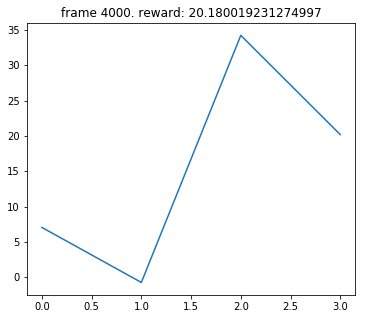

In [ ]:

frame_idx = 0
early_stop = False
while frame_idx < max_frame_idx and not early_stop:

    actions = np.zeros((batch_size, tf, num_actions))
    states = np.zeros((batch_size, tf, num_states))
    log_probs = np.zeros((batch_size, tf, num_actions))
    rewards = np.zeros((batch_size, tf))
    values = np.zeros((batch_size, tf))
    masks = np.zeros((batch_size, tf))

    state = envs.reset()
    episode_rew = 0
    for t in range(tf):
        mean, std, value = actor_critic(params, state)
        sampled_action = npr.normal(mean, std)
        log_prob = norm.logpdf(mean, sampled_action, std)

        values[:, t] = value.squeeze()
        actions[:, t, :] = sampled_action
        log_probs[:, t, :] = log_prob
        states[:, t, :] = state

        state, reward, done, _ = envs.step(sampled_action)
        rewards[:, t] = reward 
        masks[:, t] = 1-done
        
        episode_rew += np.mean(reward)
        frame_idx += 1
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(False) for _ in range(batch_size)])
            reward_history.append(test_reward)
            plot(frame_idx, reward_history)
            if test_reward > threshold_reward: early_stop = True
    # get the last state
    _, _, final_value = actor_critic(params, state)
        
    # compute cost-to-go
    rtgs = compute_gae(final_value.squeeze(), rewards, masks, values)
    advantage = rtgs - values
    
    rtgs = np.concatenate(rtgs).reshape((-1,1))
    advantage = np.concatenate(advantage).reshape((-1,1))
    log_probs = np.concatenate(log_probs)
    states = np.concatenate(states)
    actions = np.concatenate(actions)
    
    for _ in range(ppo_epochs):

        for _states, _actions, _old_log_probs, _rtgs, _advantage \
                    in ppo_iter(mini_batch_size, states, actions, log_probs, rtgs, advantage):
            update = lambda x, i : grad_loss(x, _states, _actions, _old_log_probs, _rtgs, _advantage)
            params = optimizer.step(update, params)



In [13]:
state = env.reset()
for t in range(tf):
    mean, std, value = actor_critic(params, state)
    sampled_action = npr.normal(mean, std)
    state, reward, done, _ = env.step(mean)
    env.render()
